# Questão 2

Considere umarede  de autoencoder para compressão de imagens. Defina a arquitetura da rede de autoencoderde tal modo que a imagem possa ser comprimida. (Exemplo: Uma imagem 64x64 pixel seja comprimida 32x32). Utilize uma rede neural convolucional. Pes-quise e utilize redes pré-treinadas. Pesquise umabase de dados de imagens a serem utiliza-das para o treinamento e teste.Após o treinamento  verifique a capacidade de generaliza-ção  considerando imagensdiferentes  das  utilizadas  no  treinamento.  Avalie  a  qualidade  da compressão calculando em dB a razão sinal ruído definida como $SRN = 10log_{10}(\frac{s_{méd}}{e_{méd}})$ onde $s_{méd} = \frac{1}{MN}\sum_{i=1}^N\sum_{j=1}^Mf(i,j)^2$ sendo $f(i,j)$ o valor de cada pixel na posição (i,j), M e N as dimensões da imagem e $e_{méd}$ o erro médio quadrático, isto é $e_{méd}=\frac{1}{MN}\sum_{i=1}^N\sum_{j=1}^Me(i,j)^2$ sendo $e(i,j)$ a diferença entre o pixel sem compressão e após a descompressão.

## Convolutional Autoencoder

A convolutional autoencoder is a type of neural network that is used for unsupervised learning of hierarchical representations of input data, such as images. The goal of a convolutional autoencoder is to learn a compressed representation of an input image, which can then be used to reconstruct the original image.

The architecture of a convolutional autoencoder consists of two main parts: an encoder and a decoder. The encoder takes an input image and maps it to a lower-dimensional latent representation. The decoder takes this latent representation and maps it back to the original image. The encoder and decoder are typically symmetric, with the same number of layers and feature maps.

<center><img width="500" src="https://drive.google.com/uc?export=view&id=1O3mzBdD64FGV6UlCQLlcePyEi_rtKLSH"></center>


#### Encoder
The encoder typically consists of a series of convolutional layers followed by pooling layers, which reduce the spatial dimensions of the input and increase the number of feature maps. The final output of the encoder is a flattened representation of the input image, which is then mapped to a lower-dimensional latent space using one or more fully connected layers or a bottleneck convolutional layer.

#### Decoder

The decoder takes the latent representation produced by the encoder and maps it back to the original image using a series of convolutional layers followed by upsampling layers, which increase the spatial dimensions of the input and decrease the number of feature maps. The final output of the decoder is a reconstruction of the original input image.

## Implementação

### Instalações

In [1]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


### Importando as bibliotecas

In [2]:
# import the necessary packages
import os
import cv2
import wandb
import joblib
import logging
import numpy as np
import tensorflow as tf
from imutils import paths
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from keras.applications.vgg16 import VGG16
from google.colab.patches import cv2_imshow
from skimage.metrics import peak_signal_noise_ratio
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Reshape, Dropout, Conv2DTranspose
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten
plt.style.use("ggplot")

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

### 1- Importando os dados

In [5]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"dataset": "animals",
  "project_name": "first_image_classifier",
  "artifact_name": "animals_raw_data:latest",
}

In [6]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="morsinaldo",project=args["project_name"], job_type="preprocessing")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

wandb: Currently logged in as: morsinaldo. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact animals_raw_data:latest, 187.97MB. 3000 files... 
wandb:   3000 of 3000 files downloaded.  
Done. 0:1:38.5
22-05-2023 22:20:42 Path: ./artifacts/animals_raw_data:v0


### 2- Visualizando os dados

In [7]:
# create a table with columns we want to track/compare
preview_dt = wandb.Table(columns=["id", "image", "label","size"])

# create a new artifact to store the EDA data
eda_data = wandb.Artifact("eda_animals", type="eda_data")

In [ ]:
# grab the list of images that we'll be describing
imagePaths = list(paths.list_images(data_dir))

# append all images to the artifact
for img in imagePaths:
  "img example: ./artifacts/animals_raw_data:v0/dogs/dogs_00892.jpg"
  label = img.split(os.path.sep)
  image = cv2.imread(img)
  preview_dt.add_data(label[-1], wandb.Image(img), label[-2], str(image.shape[0]) + " X " + str(image.shape[1]))

In [ ]:
# save artifact to W&B
eda_data.add(preview_dt, "EDA_Table")
run.log_artifact(eda_data)

In [ ]:
# Choose some random images from the dataset to visualize
num_images = 5

for img in imagePaths[:num_images]:
  "img example: ./artifacts/animals_raw_data:v0/dogs/dogs_00892.jpg"
  label = img.split(os.path.sep)
  image = cv2.imread(img)
  cv2_imshow(image)

### 3 - Limpando os dados

In [ ]:
# 
# a basic simple preprocessor that resize a image
#
class SimplePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation
		# method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# resize the image to a fixed size, ignoring the aspect
		# ratio
		return cv2.resize(image, (self.width, self.height),interpolation=self.inter)

In [ ]:
# Building an image loader
class SimpleDatasetLoader:
  def __init__(self, preprocessors=None, logger=None):
		# store the image preprocessor
    self.preprocessors = preprocessors
    self.logger = logger

		# if the preprocessors are None, initialize them as an
		# empty list
    if self.preprocessors is None:
      self.preprocessors = []

  def load(self, imagePaths, verbose=-1):
		# initialize the list of features and labels
    data = []
    labels = []

		# loop over the input images
    for (i, imagePath) in enumerate(imagePaths):
			# load the image and extract the class label assuming
			# that our path has the following format:
			# /path/to/dataset/{class}/{image}.jpg
			# e.g "img example: ./artifacts/animals_raw_data:v0/dogs/dogs_00892.jpg"
			# imagePath.split(os.path.sep)[-2] will return "dogs"
      image = cv2.imread(imagePath)
      label = imagePath.split(os.path.sep)[-2]

      # check to see if our preprocessors are not None
      if self.preprocessors is not None:
				# loop over the preprocessors and apply each to
				# the image
        for p in self.preprocessors:
          image = p.preprocess(image)

			# treat our processed image as a "feature vector"
			# by updating the data list followed by the labels
      data.append(image)
      labels.append(label)
   
			# show an update every `verbose` images
      if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
        logger.info("[INFO] processed {}/{}".format(i + 1,len(imagePaths)))

		# return a tuple of the data and labels
    return (np.array(data), np.array(labels))

In [ ]:
# grab the list of images that we'll be describing
logger.info("[INFO] preprocessing images...")
imagePaths = list(paths.list_images(data_dir))

# initialize the image preprocessors
sp = SimplePreprocessor(64, 64)

# load the dataset from disk then scale the raw pixel intensities
# to the range [0, 1]
sdl = SimpleDatasetLoader(preprocessors=[sp])
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.astype("float") / 255.0

# show some information on memory consumption of the images
logger.info("[INFO] features matrix: {:.1f}MB".format(data.nbytes / (1024 * 1024)))
logger.info("[INFO] labels vector: {:.1f}MB".format(labels.nbytes / (1024 * 1024)))
logger.info("[INFO] features shape: {}, labels shape: {}".format(data.shape,labels.shape))

In [ ]:
# Save the feature artifacts using joblib
joblib.dump(data, "features")

# Save the target using joblib
joblib.dump(labels, "labels")

logger.info("Dumping the clean data artifacts to disk")

### 4 - Divisão entre treinamento, teste e validação

In [ ]:
# partition the data into training, test splits using 75% of
# the data for training and the remaining 25% for test
(train_x, test_x, train_y, test_y) = train_test_split(data, labels ,test_size=0.25, random_state=42)

In [ ]:
# partition the training into training, validation splits using 75% of
# the training set for training and the remaining 25% for validation
(train_x, val_x, train_y, val_y) = train_test_split(train_x, train_y,test_size=0.25, random_state=42)

In [ ]:
logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Validation x: {}".format(val_x.shape))
logger.info("Validation y: {}".format(val_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

### 5 - Definição do modelo

In [ ]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model.summary()

Since we want 64 -> 32 -> 42, we might get only the six first layers.

In [ ]:
input_layer = Input(shape=(64, 64, 3))
encoder = Sequential()

# iterate over base model to get the pre-trained layers
for layer in base_model.layers[:6]:
  layer.trainable = False
  encoder.add(layer)

# Decoder
x = encoder(input_layer)
x = Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input_layer, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_3 (Sequential)   (None, 32, 32, 128)       260160    
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 64, 64, 32)       36896     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 3)         867       
                                                                 
Total params: 297,923
Trainable params: 37,763
Non-trainable params: 260,160
_________________________________________________________________


### Treinamento

In [ ]:
# Train model
history = autoencoder.fit(train_x, train_x, epochs=5, batch_size=32, validation_data=(val_x, val_x))

Epoch 1/5
53/53 [==============================] - 76s 1s/step - loss: 0.7761 - val_loss: 0.6261
Epoch 2/5
53/53 [==============================] - 71s 1s/step - loss: 0.6009 - val_loss: 0.5860
Epoch 3/5
53/53 [==============================] - 72s 1s/step - loss: 0.5745 - val_loss: 0.5709
Epoch 4/5
53/53 [==============================] - 71s 1s/step - loss: 0.5645 - val_loss: 0.5647
Epoch 5/5
53/53 [==============================] - 61s 1s/step - loss: 0.5591 - val_loss: 0.5604


### Avaliação do modelo

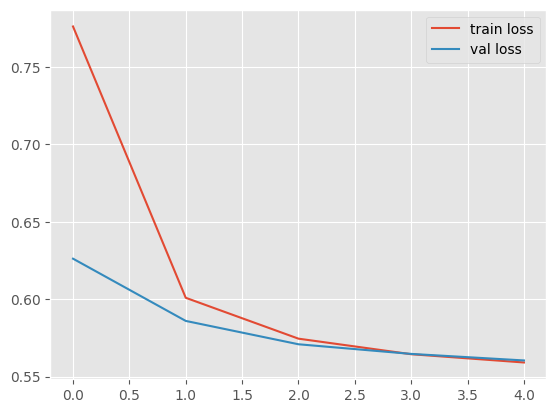

In [ ]:
# plot the loss and accuracy
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

SRN (Signal to Noise Ratio) é um indicador que analisa a qualidade de um sinal, expresso em dB, sendo definido pela relação entre sua força em comparação com a potência do ruído sobreposto a ele. Quanto maior o SNR, melhor.

In [ ]:
# Evaluate model on test set
decoded_imgs = autoencoder.predict(test_x)

# Calculate SNR
snr = peak_signal_noise_ratio(test_x, decoded_imgs)
print("SNR:", snr)

24/24 [==============================] - 16s 648ms/step
SNR: 19.361666577585225


<ipython-input-27-e39ed200cd1f>:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  snr = peak_signal_noise_ratio(test_x, decoded_imgs)


In [ ]:
snrs = []
for i in range(len(test_x)):
  snrs.append(peak_signal_noise_ratio(test_x[i], decoded_imgs[i]))

<ipython-input-33-ec80591001fe>:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  snrs.append(peak_signal_noise_ratio(test_x[i], decoded_imgs[i]))


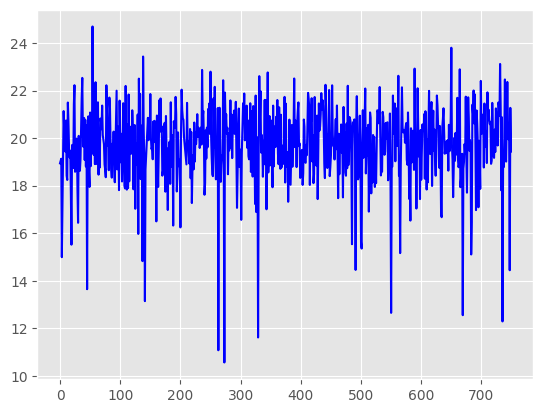

In [ ]:
plt.plot(range(len(snrs)),snrs, 'b')
plt.show()

### Visualizando as imagens

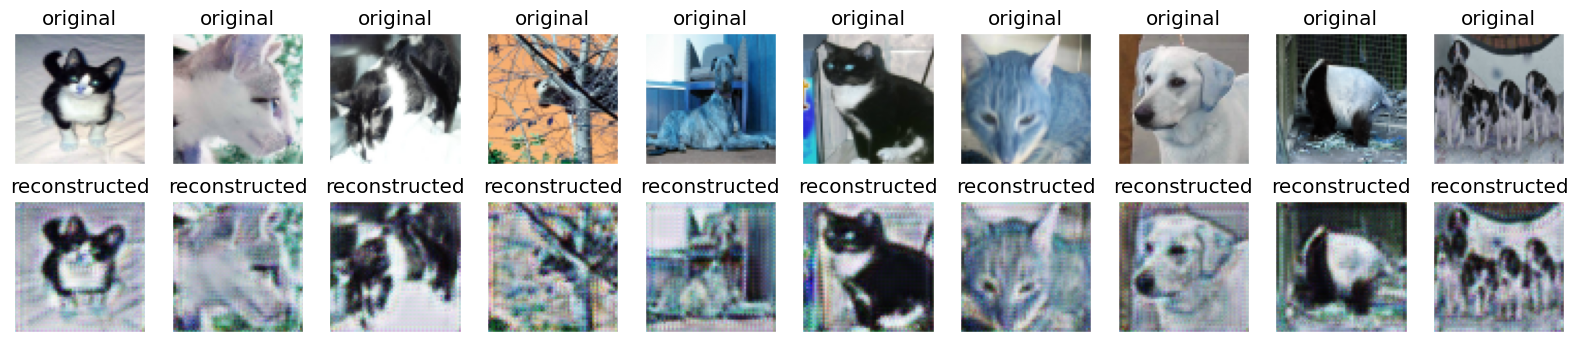

In [ ]:
# visualizing the original images and the reconstructed images (decoded images)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_x[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()